# Streaming ML Pipeline for Online Spam Detection on Streaming Data Using Apache APIs: Spark, Kafka, Spark Streaming and Structured Streaming

In this post, we will go over the following:

Running Pyspark in Colab
Overview of spark streaming and structured streaming concepts
Building feature vectors from text documents
Training a machine learning model to classify text as spam/not spam using logistic regression
Evaluating and saving the machine learning model

The following example demonstrates how to load training and testing data from two different input streams of text files, parse the streams, fit a logistic regression model online to the first stream, and make predictions on the second stream.

# Training Batch Model on Streaming Data and Serving Online  Predictions 

# Batch Logistic Regression model on streaming data

Apache Spark was build to analyze Big Data with faster speed. One of the important features that Apache Spark offers is the ability to run the computations in memory. 
PySpark is the interface that gives access to Spark using the Python programming language. PySpark is an API developed in python for spark programming and writing spark applications in Python style

In this effort, we will mostly deal with the PySpark ml - machine learning library that can be used to import the Logistic Regression model or other machine learning models.

# Running Pyspark in Colab

Google Colab?
Colab by Google is based on Jupyter Notebook which is an incredibly powerful tool that leverages google docs features. Since it runs on google server, we don't need to install anything in our system locally, be it Spark or deep learning model. The most attractive features of Colab are the free GPU and TPU support! Since the GPU support runs on Google's own server, it is, in fact, faster than some commercially available GPUs like the Nvidia 1050Ti. 

Let’s create a simple logistic regression model with PySpark in Google Colab. To open Colab Jupyter Notebook, click on this link.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark pyspark2pmml

/bin/sh: apt-get: command not found
^C
tar: Error opening archive: Failed to open 'spark-2.4.4-bin-hadoop2.7.tgz'


In [2]:
import os
# Apache Hadoop 3.x now supports only Java 8
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()


IndexError: list index out of range

## Spark ML Workflow

![alt text](presentation/SparkMLworkflow.png "Title")

In [1]:
import os
# location to stream train data from 
train_csv_dir = os.getcwd()+"/module11_cs1/train_data_csv"
# location to stream test data from
test_csv_dir = os.getcwd()+"/module11_cs1/test_data_csv"

In [2]:
# create training and testing dirs if they do not exist
if not os.path.exists(train_csv_dir):
    os.makedirs(train_csv_dir)

if not os.path.exists(test_csv_dir):
    os.makedirs(test_csv_dir)

Our Colab is ready to run PySpark. Let's build a simple Logistic Regression model.

# Import libraries

In [3]:
import os
#import pyspark
import sys
import re

import pandas as pd
import numpy as np
import time


from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext

from pyspark.streaming.kafka import KafkaUtils
from pyspark.context import SparkContext

from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql import functions as f

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors, SparseVector, DenseVector
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from pyspark2pmml import PMMLBuilder

%matplotlib inline


# Define global variables

In [4]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars jpmml-sparkml-executable-1.5.7.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3 pyspark-shell'

userSchema = StructType().add("spam", "string").add("message", "string")

dataset_df = None
# alternatilvelly, start with an intitial dataset
# dataset_df = sc.textFile("gs://drive3/data/spark/8_cs1_dataset/SMSSpamCollection").map(lambda line: re.split('\t', line)).toDF(["spam", "message"])  

checkpointDirectory = "chkpnt"

spark = None

model = None

prev_length = 0

graph_flag = True

evaluate = True
# duration of training a model on entire batch dataset
train_duration = 15  # train a model every n seconds


## Training model in time intervals using Spark Streaming

For a Spark Streaming application running on a cluster to be stable, the system should be able to process data as fast as it is being received, so the batch processing time should be less than the batch interval.
The batch interval needs to be set such that the expected data rate in production can be sustained.
We will test it with a conservative batch interval (say, 5-20 seconds) and a low data rate. To verify whether the system is able to keep up with the data rate.

In [5]:


def train(rdd):
    global dataset_df
    global model
    global prev_length
    global evaluate
    global crossval_full
    global graph_flag

    if dataset_df.count() > prev_length:
        prev_length = dataset_df.count()

        if evaluate == True:
            # Split to train and test
            (trainingData, testData) = dataset_df.randomSplit([0.7, 0.3], seed=0)
        else:
            trainingData = dataset_df

        my_train_df = trainingData

        print("\n\nStarting to fit a model on " + str(my_train_df.count()) +" records")
        
        model = crossval_full.fit(my_train_df)
        print("Model fit compleeted\n")
        
        if evaluate == True:
            predictions = model.transform(testData)
            evaluator = BinaryClassificationEvaluator().setLabelCol("label").setRawPredictionCol("prediction").setMetricName("areaUnderROC")
            accuracy = evaluator.evaluate(predictions)
            print("Evalluated on "+ str(predictions.count()) +" records")
            print ("Accuracy", accuracy)
            
            if graph_flag:
                # plot graph once only ! after first training
                plot_roc(predictions)
                graph_flag = False

                


![alt text](presentation/trainValidate.png "Title")

## Starting and Checkpointing StreamingContext for fault-tolerant spark streaming

In [6]:


# Function to create and setup a new StreamingContext
def functionToCreateContext():
    global spark
    global sc
    global dataset_df
    global userSchema
    global train_duration
    
    sc = SparkContext("local[2]", "Batch_Model_on_Stream_Data")  # new context
    ssc = StreamingContext(sc, train_duration)
    
    spark = SparkSession(sc)
    sqlContext = SQLContext(sc)
    # create an empty datframe
    dataset_df = sqlContext.createDataFrame(sc.emptyRDD(), userSchema)

    emptly_stream = ssc.queueStream([dataset_df.limit(1).rdd], oneAtATime=True, default=dataset_df.limit(1).rdd)  # create DStream
    emptly_stream.foreachRDD(train)
    ssc.start() 

    ssc.checkpoint(checkpointDirectory)  # set checkpoint directory
    return ssc



In [7]:
# Get StreamingContext from checkpoint data or create a new one
context = StreamingContext.getOrCreate(checkpointDirectory, functionToCreateContext)

In [8]:
sc

<SparkContext master=local[2] appName=Batch_Model_on_Stream_Data>

## Cross-validation Model Pipeline definition

In [9]:
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel

indexer = StringIndexer().setInputCol("spam").setOutputCol("label")
# Extract words
tokenizer = Tokenizer().setInputCol("message").setOutputCol("words")
# Remove custom stopwords
stopwords = StopWordsRemover().getStopWords() + ["-"]
remover = StopWordsRemover().setStopWords(stopwords).setInputCol("words").setOutputCol("filtered")
# create features
# cvmodel = CountVectorizer().setInputCol("filtered").setOutputCol("features")
hashingTF = HashingTF(numFeatures=10, inputCol="filtered", outputCol="features")
rf = RandomForestClassifier().setFeaturesCol("features").setNumTrees(10)
#dt = DecisionTreeClassifier()
lr = LogisticRegression(maxIter=10)

full_pipeline = Pipeline().setStages([ indexer, tokenizer, remover, hashingTF, lr])


paramGrid = ParamGridBuilder() \
.addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
.addGrid(lr.regParam, [0.1, 0.01]) \
.build()


crossval_full = CrossValidator(estimator=full_pipeline,
                            estimatorParamMaps=paramGrid,
                            evaluator=BinaryClassificationEvaluator(),
                            numFolds=2)  # use 3+ folds in practice



We will use an ML Pipeline to pass the data through transformers in order to extract the features and an estimator to produce the model.

Transformer: A transformer is an algorithm that transforms one DataFrame into another DataFrame. We will use transformers to get a DataFrame with a features vector column.
Estimator: An estimator is an algorithm that can be fit on a DataFrame to produce a transformer. We will use an estimator to train a model, which can transform input data to get predictions.
Pipeline: A pipeline chains multiple transformers and estimators together to specify an ML workflow.

![alt text](presentation/pipeline.png "Title")

In [10]:
def plot_roc(predictions):
    
    results = predictions.select(['probability', 'label'])

    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = sc.parallelize(results_list)

    metrics = metric(scoreAndLabels)
    print("\nTest Data Aread under ROC score is : ", metrics.areaUnderROC, "\n")
            
 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    %matplotlib inline
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Graph')
    plt.legend(loc="lower right")
    plt.show()



## Machine Learning Workflow

![alt text](presentation/MachineLearningWorkflow.png "Title")

# Stream training data form a directory of csv files

In [11]:
# Append dataset_df with data from each batch
def sendPartition(df, epoch_id):
    global dataset_df
    
    if not len(df.head(1)) == 0:
        dataset_df = df.union(dataset_df)




Starting to fit a model on 3920 records
Model fit compleeted

Evalluated on 1654 records
Accuracy 0.8895487298485588

Test Data Aread under ROC score is :  0.980227161700049


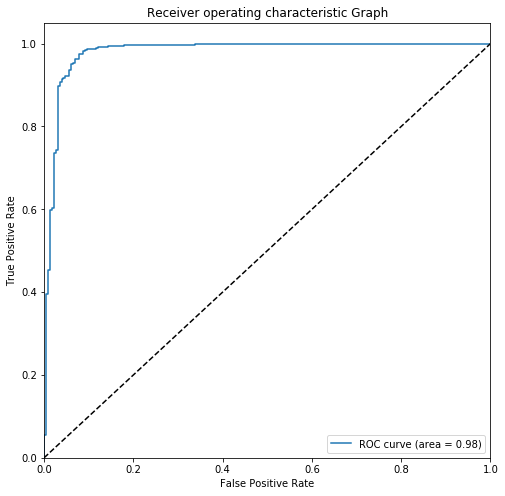

In [12]:
# screen subfolders in working directory for new csv files
# and append new batches or raw data to dataset_df
df = spark \
    .readStream \
    .option("sep", "\t") \
    .schema(userSchema)  \
    .csv(train_csv_dir) \
    .writeStream.foreachBatch(sendPartition)\
    .start()

# allow first training to finish
time.sleep(train_duration*4)

In [ ]:
# alternativelly, subscribe to a kafka topic
#df = spark \
#    .readStream \
#    .format("kafka") \
#    .option("kafka.bootstrap.servers", "localhost:9092") \
#    .option("subscribe", "sample-topic") \
#    .option("startingOffsets", "earliest") \
#    .load()

#df = df.selectExpr( "CAST(value AS STRING)")

# split text lines into two fields
#split_col = f.split(df['value'], '\t')
#df = df.withColumn('spam', split_col.getItem(0)).withColumn('message', split_col.getItem(1))
#df = df.select(['spam', 'message'])


# Serve real-time predictions with structured streaming

![alt text](presentation/structured-streaming-kafka-blog-image-1-overview.png "Title")


Now we register the stream for testing and start the job.

In [13]:
# compute predictions on every batch
def predict(df, epoch_id):
    global model
    
    if not len(df.head(1)) == 0:
        if not model == None:
            print("Predictions:")
            predictions = model.transform(df)['spam', 'message','label', 'prediction', 'probability']
            # print predictions to the console
            predictions.show()

        else:
            print("Model has not seen training data yet, therefore - no model exists")

In [14]:
# output predictions to foreachBatch sink
df_test = spark \
    .readStream \
    .option("sep", "\t") \
    .schema(userSchema)  \
    .csv(test_csv_dir)\
    .writeStream.foreachBatch(predict)\
    .start()



In [15]:
# output predictions to the console window
df_predictions = model.transform(
    spark \
    .readStream \
    .option("sep", "\t") \
    .schema(userSchema)  \
    .csv(test_csv_dir)\
)['spam', 'message','label', 'prediction', 'probability'].writeStream.format("console").start()

Predictions:
+----+--------------------+-----+----------+--------------------+
|spam|             message|label|prediction|         probability|
+----+--------------------+-----+----------+--------------------+
| ham|Go until jurong p...|  0.0|       0.0|[0.98331389758221...|
| ham|Ok lar... Joking ...|  0.0|       0.0|[0.98191730875921...|
|spam|Free entry in 2 a...|  1.0|       1.0|[0.01857597772401...|
| ham|U dun say so earl...|  0.0|       0.0|[0.97832246220121...|
| ham|Nah I don't think...|  0.0|       0.0|[0.94812958970465...|
|spam|FreeMsg Hey there...|  1.0|       1.0|[0.36635076043752...|
| ham|Even my brother i...|  0.0|       0.0|[0.96741317460673...|
| ham|As per your reque...|  0.0|       0.0|[0.94712526066206...|
|spam|WINNER!! As a val...|  1.0|       1.0|[0.05101474425265...|
|spam|Had your mobile 1...|  1.0|       1.0|[0.06212898426081...|
| ham|I'm gonna be home...|  0.0|       0.0|[0.99140294905419...|
|spam|SIX chances to wi...|  1.0|       1.0|[0.12108851195747..

Stream processing on Sprak SQL engine is fast scalable, fault-tolerant.

We can now save text files with data to the training or testing folders. Anytime a text file is placed in sys.argv[1] the model will update. Anytime a text file is placed in sys.argv[2] you will see predictions. As you feed more data to the training directory, dataset_df gets appended with the new batch. The next scheduled model training with use data from appended dataset_df. 

# Saving the model File

In [19]:
modeldirectory = "module11_cs1/model"

We can now save our fitted pipeline model to the distributed file store for later use in production. This saves both the feature extraction stage and the logistic regression model in the pipeline.

In [20]:
pip_model = model.bestModel
pip_model.write().overwrite().save(modeldirectory)

The result of saving the pipeline model is a JSON file for metadata and Parquet files for model data. We can reload the model with the load command; the original and reloaded models are the same:

In [21]:
sameModel = PipelineModel.load(modeldirectory)

In [ ]:

# Start the computation
context.awaitTermination()  # Wait for the computation to terminate
#print(flag)

# Summary
There are plenty of great tools to build classification models. Apache Spark provides an excellent framework for building solutions to business problems that can extract value from massive, distributed datasets.

Machine learning algorithms cannot answer all questions perfectly. But they do provide evidence for humans to consider when interpreting results, assuming the right question is asked in the first place.

# Code
All of the data and code to train the models and make your own conclusions, using Apache Spark, are located in GitHub;

https://github.com/voklymchuk/spark/blob/master/module11_cs1_train_predict_batch_on_streams.ipynb


Colab viewer of notebook: https://colab.research.google.com/github/voklymchuk/spark/blob/master/module11_cs1_train_predict_batch_on_streams.ipynb